In [1]:
#We'll be using LSTM (Long Short-Term Memory network)- "type of recurrent neural network capable of remembering the past information and while predicting the future values, it takes this past information into account."
#april 1st 2013 to dec 31 2018

#Libraries and data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Read data
df=pd.read_csv('weather_train.csv')

In [3]:
#explore data
print(df.head())
df.shape

       STATION                                   NAME      DATE  TAVG
0  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  4/1/2013    60
1  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  4/2/2013    57
2  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  4/3/2013    53
3  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  4/4/2013    57
4  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  4/5/2013    57


(2101, 4)

In [4]:
#We only care about the average temp
df_training_processed = df.iloc[:, 3:4].values
df_training_processed

array([[60],
       [57],
       [53],
       ...,
       [48],
       [48],
       [39]], dtype=int64)

In [5]:
#Data scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1)) #scale the data between 0 and 1
df__training_scaled = scaler.fit_transform(df_training_processed)

c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
#predicting the avg temp based on the avg temp for the past 60 days
"the feature set should contain the temp values for the past 60 days"
"the label (dependent var.) should be the temp at the 61st day"
features_set = []
labels = []
for i in range(60, 2101): #the data has 2101 records
    features_set.append(df__training_scaled[i-60:i, 0]) #loop that starts from 61st record and stores all the previous 60 records to the feature_set list"
    labels.append(df__training_scaled[i, 0]) #the 61st record is stored in the labels list

features_set, labels = np.array(features_set), np.array(labels)  #convert to numpy array
#LSTM required a 3 dimension format so we'll convert ours.

#The three dimensions of this input are:

#Samples. One sequence is one sample. A batch is comprised of one or more samples.
#Time Steps. One time step is one point of observation in the sample.
#Features. One feature is one observation at a time step.

#in ours:
#first dimension is the number of records or rows (1511 here)
#second dimension is the number of time steps (60 here)
#third dimension is the number of indicators (we are only using 1 feature - temp, so 1 indicator)

#This means that the input layer expects a 3D array of data when fitting the model and when making predictions

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
print(features_set.shape)
#an example with 1 sample:
#data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
#Convert to 3D: data = data.reshape((1, 10, 1)) --> 1 sample, 10 time steps, and 1 feature at each time step.
#This data is now ready to be used as input (X) to the LSTM with an input_shape of (10, 1).
#model.add(LSTM(32, input_shape=(10, 1))) --> it assumes at least 1 sample  so you dont need to specify how many samples

#an example with 2 samples (multiple parallel series):
#series 1: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
#series 2: 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1

#define these data as a matrix of 2 columns with 10 rows:
'''data = array([
	[0.1, 1.0],
	[0.2, 0.9],
	[0.3, 0.8],
	[0.4, 0.7],
	[0.5, 0.6],
	[0.6, 0.5],
	[0.7, 0.4],
	[0.8, 0.3],
	[0.9, 0.2],
	[1.0, 0.1]])'''
#This data can be framed as 1 sample with 10 time steps and 2 features.
#data = data.reshape(1, 10, 2)
#model.add(LSTM(32, input_shape=(10, 2)))--> again, dont need to specify the amount of samples


(2041, 60, 1)


'data = array([\n\t[0.1, 1.0],\n\t[0.2, 0.9],\n\t[0.3, 0.8],\n\t[0.4, 0.7],\n\t[0.5, 0.6],\n\t[0.6, 0.5],\n\t[0.7, 0.4],\n\t[0.8, 0.3],\n\t[0.9, 0.2],\n\t[1.0, 0.1]])'

In [7]:
#Define the model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential() #the model class. We will add LSTM, Dropout and Dense layers to this model.
#CuDNNLSTM are normal LSTM accelerated via CUDA, so runs faster on a GPU 

#Creating LSTM and Dropout Layers
model.add(LSTM(units=50, return_sequences=True, activation='relu',input_shape=(features_set.shape[1], 1))) #use add() to add a layer
#The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. 
#The second parameter is return_sequences, set to true since we will add more LSTM layers to the model:
#it basically returns a sequence-if we were to put a dense layer afterwards we would set it to false.

#When defining the input layer of your LSTM network, the network assumes you have 1 or more samples and requires 
#that you specify the number of time steps and the number of features.

#Ours: The first parameter to the input_shape is the number of time steps while the last parameter is the number of indicators (features)


#Adding a dropout layer to our model (to avoid over-fitting)
model.add(Dropout(0.2))

#Adding three more LSTM and dropout layers to our model
model.add(LSTM(units=50, return_sequences=True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True,activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

#Creating Dense Layer
"To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer" \
" will be set to 1 since we want to predict a single value in the output"
model.add(Dense(units = 1)) #how many classes we have - 1 (e.g if we had digits it would be 10)

#Define another optimizer
#opt=keras.optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5) 
#the lr is the step size, the decay makes the step size smaller after time

Using TensorFlow backend.


In [8]:
#Compile the LSTM
#adam optimizer to reduce the loss or to optimize the algorithm
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #mean squared error as loss function

In [19]:
#Training
model.fit(features_set, labels, epochs = 30, batch_size = 32)

Epoch 1/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0092
Epoch 2/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0086
Epoch 3/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0086
Epoch 4/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0088
Epoch 5/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0085
Epoch 6/30
2041/2041 [==============================] - 10s 5ms/step - loss: 0.0083
Epoch 7/30
2041/2041 [==============================] - 11s 5ms/step - loss: 0.0082
Epoch 8/30
2041/2041 [==============================] - 11s 5ms/step - loss: 0.0078
Epoch 9/30
2041/2041 [==============================] - 11s 5ms/step - loss: 0.0078
Epoch 10/30
2041/2041 [==============================] - 11s 5ms/step - loss: 0.0081
Epoch 11/30
2041/2041 [==============================] - 11s 5ms/step - loss: 0.0080
Epoch 12/30
2041/2041 [==============================] - 11s 5ms/step - lo

In [20]:
#Testing
#Importing the testing data
df_test_complete = pd.read_csv('weather_test.csv')

In [21]:
#explore data
print(df_test_complete.head())
df_test_complete.shape

       STATION                                   NAME      DATE  TAVG
0  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/1/2019    35
1  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/2/2019    35
2  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/3/2019    47
3  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/4/2019    50
4  USW00024229  PORTLAND INTERNATIONAL AIRPORT, OR US  1/5/2019    44


(27, 4)

In [22]:
#preprocess
df_test_processed = df_test_complete.iloc[:, 3:4].values

In [23]:
#Converting Test Data to Right Format
df_total = pd.concat((df['TAVG'], df_test_complete['TAVG']), axis=0)
test_inputs = df_total[len(df_total) - len(df_test_complete) - 60:].values

In [24]:
#Scaling
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [25]:
#Prepating the testing data
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

In [26]:
#Convert to 3 dimensions
#first dimension is the number of records or rows (27 here)
#second dimension is the number of time steps (60 here)
#third dimension is the number of indicators (we are only using 1 feature - temp, so 1 indicator)
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [27]:
#Predictions
predictions = model.predict(test_features)
"Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values."
predictions = scaler.inverse_transform(predictions)

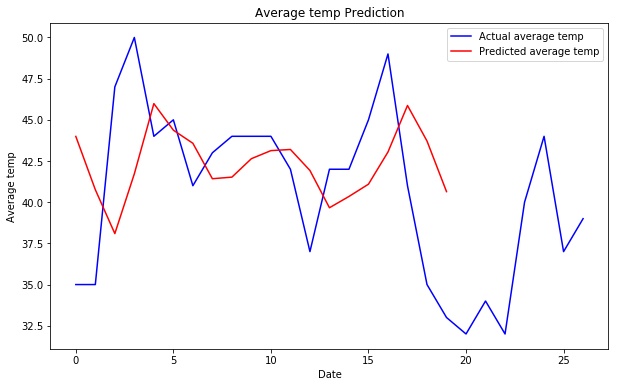

In [28]:
#Plotting
plt.figure(figsize=(10,6))
plt.plot(df_test_processed, color='blue', label='Actual average temp')
plt.plot(predictions, color='red', label='Predicted average temp')

plt.title('Average temp Prediction')
plt.xlabel('Date')
plt.ylabel('Average temp')
plt.legend()
plt.show()